# Goal : Make t-SNE figure from esm2 embedding representation of the proteins on which a fold was identified.
### 3 Dataset : phagedepo_out , CAZY hits , PL16
***
## I. Make multifasta 
## II. esm2 predictions
## III. Visualization t-SNE
***

In [11]:
import os
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
from Bio import SeqIO
from tqdm import tqdm 

def pdb_to_sequence(file_path):
    parser = PDBParser()
    structure = parser.get_structure('protein', file_path)
    ppb = PPBuilder()
    for pp in ppb.build_peptides(structure):
        sequence = pp.get_sequence()
        return sequence
        


> The PhageOut DB

In [39]:
import pandas as pd
import os 

path_project = "/media/concha-eloko/Linux/depolymerase_building"
dir_out = f"{path_project}/seekfold_phagedepo"
path_pdb = f"{path_project}/phagedepo_out"
path_info = f"/media/concha-eloko/Linux/depolymerase_building/depolymerase_fold.csv"

info_df = pd.read_csv(path_info , sep = "\t", header = 0)
dico_folds = {"jelly-roll" : [],
              "alpha/alpha toroid" : [],
              "right-handed beta-helix" : [] ,
              "TIM beta/alpha-barrel" : [],
              "6-bladed beta-propeller" : [] ,
              "Flavodoxin-like" : [] ,
              "Alpha/Beta hydrolase fold" : [] ,
              "Other" : [],
             }

outputs = [f"{dir_out}/{file}" for file in os.listdir(dir_out) if file[-3:]=="out"]
header_seekfold = ["query","target","pident","alnlen","gapopen","qstart","qend","tstart","tend","bits","prob"]
depo_results = {}
for results in outputs :
    results_df = pd.read_csv(f"{results}", sep = "\t" , names = header_seekfold)
    for _,row in results_df.iterrows() :
        fold = info_df[info_df["ID"] == row["target"]]["X_Group_Name"].values[0]
        if row["prob"] >= 0.2 :
            if row["query"] not in dico_folds[fold] :
                dico_folds[fold].append(row["query"])
        elif fold == "right-handed beta-helix" and row["prob"] >= 0.2 :
            if row["query"] not in dico_folds[fold] :
                dico_folds[fold].append(row["query"])


In [41]:
dico_data_final = {}

In [42]:
import warnings
warnings.filterwarnings("ignore") 
for fold in tqdm(dico_folds) :
    if fold not in ["jelly-roll" , "Other"] and len(dico_folds[fold]) > 0:
        if fold == "6-bladed beta-propeller" :
            fold_name = "n-bladed beta-propeller"
        else :
            fold_name = fold
        for _,protein in enumerate(dico_folds[fold]) :
            seq = pdb_to_sequence(f"{path_pdb}/{protein}")
            a = {protein : {"Dataset" : "PhageDepo_out", "Seq" : seq}}
            if fold_name not in dico_data_final :
                dico_data_final[fold_name] = a
            else :
                dico_data_final[fold_name].update(a)
            


100%|██████████████████████████████████████████████████████████| 8/8 [01:50<00:00, 13.86s/it]


In [43]:
dico_data_final

{'alpha/alpha toroid': {'2170.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MASKKIRILTPEQAHALYALPARLTAAGVTNTIQGMLDSIALGNIMSAGANVFN...GAR')}},
 'right-handed beta-helix': {'5416.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MTTKVNNRMIDGAAVNVLDFGADPKGVSDSTTAFQSAIDSINGGKLIVPEGTYY...ASH')},
  '3777.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MNPQFAQPKGSTSKESNKDSIARKFGCKKSEVVYAKAGQSLSGYKVIYDKLSQR...VIG')},
  '4603.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MAIAIVEELWTRIRSAIDDKIIAAQDAVDRAATSATNAKTSETAAAQSASEAEA...YNW')},
  '6115.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MSSSCGGVMSLNDLQIAKKHQIFEAEVITGKQGGVAGGADIDYATNQVTGQTQK...TLA')},
  '1809.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MATTPTSLPIPSEDPRDLKFNAGKFDEVMTSDAHYYVDRFGVKRWTIAGFQYTA...TLA')},
  '5282.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MGYFQMTRNVEELFGGVITAPHQIPFTYKSNVGGETFLSLPFYPVTGVVTINGG...SSI')},
  '1856.pdb': {'Dataset': 'PhageDepo_out',
   'Seq': Seq('MATTPTSLPIPSEDPRDLKFNAGKFDEVMTS

> CAZY dataset

In [44]:
import pandas as pd
import os 

path_project = "/media/concha-eloko/Linux/depolymerase_building"
dir_out = f"{path_project}/CAZY_seekfold"

path_info = f"/media/concha-eloko/Linux/PhageDEPOdetection/PDB_files/folds_CAZY.tsv"
info_df = pd.read_csv(path_info , sep = "\t", header = 0)

outputs = [f"{dir_out}/{file}" for file in os.listdir(dir_out) if file[-3:]=="out"]
header_seekfold = ["query","target","pident","alnlen","gapopen","qstart","qend","tstart","tend","bits","prob"]
depo_results = {}
for results in tqdm(outputs) :
    results_df = pd.read_csv(f"{results}", sep = "\t" , names = header_seekfold)
    for _,row in results_df.iterrows() :
        if row["prob"] >= 0.5 :
            try : 
                fold = info_df[info_df["Protein"] == row["target"]]["Folds"].values[0]
                if row["alnlen"] >= 250 :
                    if fold not in ["β-jelly roll"] :
                        if fold.count("propeller") > 0 : 
                            fold = "n-bladed beta-propeller"
                        elif fold.count("α / α") > 0 and fold.count("barrel") > 0 :
                            fold = "(α / α) n barrel"
                        elif fold.count("β / α") > 0 and fold.count("barrel") > 0 :
                            fold = "(β / α) n barrel"                            
                        else :
                            break
                        seq = pdb_to_sequence(f"{path_pdb}/{row['query']}")
                        a = {row['query'] : {"Dataset" : "CAZY", "Seq" : seq}}
                        if fold not in dico_data_final :
                            dico_data_final[fold] = a
                        else :
                            dico_data_final[fold].update(a)
            except Exception as e :
                pass

100%|██████████████████████████████████████████████████████| 990/990 [00:46<00:00, 21.42it/s]


In [29]:
import pandas as pd
import os 

path_project = "/media/concha-eloko/Linux/depolymerase_building"
dir_out = f"{path_project}/CAZY_seekfold"

path_info = f"/media/concha-eloko/Linux/PhageDEPOdetection/PDB_files/folds_CAZY.tsv"
info_df = pd.read_csv(path_info , sep = "\t", header = 0)

outputs = [f"{dir_out}/{file}" for file in os.listdir(dir_out) if file[-3:]=="out"]
header_seekfold = ["query","target","pident","alnlen","gapopen","qstart","qend","tstart","tend","bits","prob"]
depo_results = {}
for results in tqdm(outputs) :
    results_df = pd.read_csv(f"{results}", sep = "\t" , names = header_seekfold)
    for _,row in results_df.iterrows() :
        if row["prob"] >= 0.5 :
            try : 
                fold = info_df[info_df["Protein"] == row["target"]]["Folds"].values[0]
                print(fold)
            except Exception as e :
                print(fold)
                print(e)
                pass

  1%|▍                                                       | 8/990 [00:00<00:12, 77.60it/s]

['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
['parallel β-helix']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]


  3%|█▌                                                     | 28/990 [00:00<00:11, 83.14it/s]

[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
['5-fold β-propeller']
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
['parallel β-helix']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
['β-propeller']
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
['β-jelly roll' 'β-jelly roll']
['( α / α ) 6 barrel']
['( α / α ) 7 barrel']
['5-fold β-propeller']
['( α / α ) 6 barrel']
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 7 bar

  6%|███▏                                                   | 57/990 [00:00<00:10, 87.00it/s]

['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]


  8%|████▍                                                  | 79/990 [00:00<00:09, 97.31it/s]

['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
['( β / α ) 8 barrel']
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 11%|█████▉                                                | 109/990 [00:01<00:09, 92.97it/s]

['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
['β-jelly roll' 'β-jelly roll']
['β-jelly roll']
['5-fold β-propeller']


 12%|██████▌                                               | 121/990 [00:01<00:08, 98.22it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['parallel β-helix']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
['5-fold β-propeller']
['( α / α ) 6 barrel']
['5-fold β-propeller']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['parallel β-helix']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']


 14%|███████▋                                              | 140/990 [00:01<00:10, 83.62it/s]

['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 (inferred)']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['β-jelly roll']
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
['5-fold β-propeller']
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['β-jelly roll']
[]
['β-jelly roll']
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
['β-jelly roll']
[]
['β-jelly roll']
['β-jelly roll']
[]
[]
[]
[]
[]
[]


 16%|████████▌                                             | 158/990 [00:01<00:11, 73.70it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
['5-fold β-propeller']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
['β-jelly roll']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]


 18%|█████████▋                                            | 177/990 [00:02<00:09, 81.82it/s]

[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
[]


 20%|██████████▉                                           | 201/990 [00:02<00:08, 96.75it/s]

[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
['β-jelly roll']
['β-jelly roll' 'β-jelly roll']
[]
['β-jelly roll']
['( β / α ) 8 barrel']
[]
[]
['β-jelly roll']
['5-fold β-propeller']
[]
['5-fold β-propeller']
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
['β-propeller' 'β-propeller']
[]
['β-jelly roll' 'β-jelly roll']
['( β / α ) 8 barrel']
[]


 23%|████████████▏                                         | 224/990 [00:02<00:08, 91.69it/s]

['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
['( α / α ) 7 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
['( β / α ) 8 barrel']
['5-fold β-propeller']
['5-fold β-propeller']
[]
[]
[]
['parallel β-helix']
[]
[]


 25%|█████████████▎                                        | 244/990 [00:02<00:08, 87.21it/s]

[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['β-jelly roll']
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['5-fold β-propeller']
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]


 27%|██████████████▍                                       | 264/990 [00:03<00:08, 88.29it/s]

[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['5-fold β-propeller']
[]
[]
['5-fold β-propeller']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
['( β / α ) 8 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]


 30%|████████████████▏                                     | 296/990 [00:03<00:07, 95.89it/s]

[]
[]
['β-jelly roll' 'β-jelly roll']
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['parallel β-helix']
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['5-fold β-propeller']
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
['5-fold β-propeller']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['β-propeller' 'β-propeller']


 31%|████████████████▋                                     | 306/990 [00:03<00:07, 91.89it/s]

[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
['lysozyme fold']
[]
[]
[]
['lysozyme fold']
[]
['( β / α ) 8 barrel']
[]
[]
[]
['parallel β-helix']
['( β / α ) 8 barrel']
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['lysozyme fold']
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
['parallel β-helix']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['β-propeller' 'β-propeller']
['( β / α ) 8 barrel']
['( β / α ) 8 barrel

 34%|██████████████████▎                                   | 335/990 [00:03<00:07, 89.09it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
['parallel β-helix']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
['parallel β-helix']
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
['( β / α ) 8 barrel']


 36%|███████████████████▎                                  | 355/990 [00:04<00:07, 87.20it/s]

[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]


 38%|████████████████████▎                                | 379/990 [00:04<00:05, 102.22it/s]

[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
['parallel β-helix']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 41%|█████████████████████▉                                | 402/990 [00:04<00:06, 91.68it/s]

['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
['( α / α ) 6 barrel']
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( β / α ) 8 barrel']


 43%|███████████████████████▏                              | 424/990 [00:04<00:05, 94.75it/s]

[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']


 45%|████████████████████████▏                             | 444/990 [00:04<00:06, 90.55it/s]

[]
[]
[]
['( β / α ) 8 barrel']
['5-fold β-propeller']
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
['parallel β-helix']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
['β-jelly roll' 'β-jelly roll']
['5-fold β-propeller']
[]
[]
[]
[]
['β-jelly roll']
[]
['β-jelly roll']
[]
['β-jelly roll']
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['β-jelly roll']
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
['β-jelly roll

 47%|█████████████████████████▎                            | 463/990 [00:05<00:06, 75.52it/s]

['β-jelly roll' 'β-jelly roll']
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
['β-jelly roll']
[]
[]
['β-jelly roll']
[]
[]
[]
[]
['β-jelly roll']
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
['5-fold β-propeller']
[]
[]
['β-jelly roll']
[]
['5-fold β-propeller']
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
['β-jelly roll']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 7 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['β-jelly roll']
['5-fold β-propeller']
['5-fold β-propeller']
[]
['β-jelly roll']
[]
[]
['β-jelly roll' 'β

 49%|██████████████████████████▏                           | 481/990 [00:05<00:06, 76.88it/s]


[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]

 50%|███████████████████████████▏                          | 499/990 [00:05<00:06, 80.88it/s]


[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
['( β / α ) 8 barrel']
[]
['β-jelly roll']
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
['5-fold β-propeller']
['5-fold β-propeller']
['parallel β-helix']
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['parallel β-helix']
['( β / α ) 8 barrel']
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
['( β / α ) 8 barrel']


 52%|████████████████████████████▏                         | 517/990 [00:05<00:06, 78.67it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 7 barrel']
[]
[]
[]
[]
[]
['lysozyme fold']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['β-propeller' 'β-propeller']
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
['parallel β-helix']


 54%|█████████████████████████████                         | 533/990 [00:06<00:06, 71.57it/s]

[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
['parallel β-helix']
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
['( β / α ) 8 barrel']
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
['5-fold β-propeller']
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
['( β / α ) 8 barrel']
[]

 55%|█████████████████████████████▌                        | 541/990 [00:06<00:06, 70.27it/s]


['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['5-fold β-propeller']
['( β / α ) 8 barrel']
['5-fold β-propeller']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]


 56%|██████████████████████████████▍                       | 557/990 [00:06<00:06, 68.31it/s]

[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
['parallel β-helix']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
['5-fold β-propeller']
[]
[]
['( β / α ) 8 barrel']
[]
['parallel β-helix']


 58%|███████████████████████████████▍                      | 576/990 [00:06<00:05, 78.86it/s]

['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
['parallel β-helix']
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
[]
['( α / α ) 6 barrel']
['5-fold β-propeller']
['5-fold β-propeller']
[]
[]
['β-jelly roll']
['5-fold β-propeller']
[]
[]
[]
['β-jelly roll']
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
['β-jelly roll']
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
['β-jelly roll']
['β-jelly roll']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]


 60%|████████████████████████████████▌                     | 597/990 [00:07<00:04, 83.89it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
[]
[]


 62%|█████████████████████████████████▌                    | 615/990 [00:07<00:05, 69.66it/s]

[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['5-fold β-propeller']
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
['( β / α ) 8 barr

 63%|██████████████████████████████████▏                   | 626/990 [00:07<00:04, 75.82it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
['5-fold β-propeller']
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
['β-jelly roll']
['β-jelly roll']
[]
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
['β-propeller']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 66%|███████████████████████████████████▉                  | 658/990 [00:07<00:03, 87.00it/s]

[]
[]
['parallel β-helix']
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]


 67%|████████████████████████████████████▍                 | 668/990 [00:07<00:03, 84.51it/s]

['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
['β-propeller' 'β-propeller']
[]
['( α / α ) 6 barrel']
[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['parallel β-helix']
[]
[]
['5-fold β-propeller']
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
['β-propeller']
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
['parallel β-helix']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 69%|█████████████████████████████████████▍                | 686/990 [00:08<00:03, 78.27it/s]

['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
['( β / α ) 8 barrel']
['5-fold β-propeller']
['5-fold β-propeller']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['β-jelly roll']
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
['parallel β-helix']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
['5-fold β-propeller']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['parallel β-helix']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['5-fold β-pro

 72%|██████████████████████████████████████▊               | 712/990 [00:08<00:03, 79.54it/s]

[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 74%|████████████████████████████████████████              | 734/990 [00:08<00:02, 93.79it/s]

[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']


 76%|█████████████████████████████████████████▏            | 754/990 [00:09<00:02, 90.33it/s]

['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['5-fold β-propeller']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]


 77%|█████████████████████████████████████████▋            | 764/990 [00:09<00:02, 78.69it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['5-fold β-propeller']
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
['β-jelly roll']
[]
['5-fold β-propeller']
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 79%|██████████████████████████████████████████▌           | 781/990 [00:09<00:02, 73.81it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['5-fold β-propeller']
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['5-fold β-propeller']
['5-fold β-propeller']
[]
['5-fold β-propeller']


 81%|███████████████████████████████████████████▌          | 799/990 [00:09<00:02, 75.40it/s]

[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']


 82%|████████████████████████████████████████████          | 808/990 [00:09<00:02, 71.23it/s]

['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['β-jelly roll']
[]
[]
['5-fold β-propeller']
[]
[]
[]
['β-jelly roll' 'β-jelly roll']
['β-jelly roll']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
['5-fold β-propeller']
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
[]
['β-jelly roll']
[]
[]
['β-jelly roll']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['parallel β-helix']
['( α / α ) 6 toroid + anti-parallel β-sheet']
['5-fold β-propeller']
[]
[]
['( β / α ) 8 barrel']
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']


 84%|█████████████████████████████████████████████         | 827/990 [00:10<00:02, 78.91it/s]

[]
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
['( α / α ) 6 barrel']
['5-fold β-propeller']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
['β-jelly roll']
[]
[]
['β-jelly roll']


 85%|██████████████████████████████████████████████        | 844/990 [00:10<00:02, 72.53it/s]

['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
['lysozyme fold']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['parallel β-helix']
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['parallel β-helix']
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]


 88%|███████████████████████████████████████████████▌      | 873/990 [00:10<00:01, 86.74it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
['lysozyme fold']
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
['5-fold β-propeller']
[]
[]


 90%|████████████████████████████████████████████████▊     | 894/990 [00:10<00:01, 95.47it/s]

[]
[]
['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
[]
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['parallel β-helix']
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 (inferred)']
[]

 92%|█████████████████████████████████████████████████▊    | 913/990 [00:11<00:00, 82.30it/s]


[]
['( β / α ) 8 barrel']
['5-fold β-propeller']
[]
[]
[]
[]
['5-fold β-propeller']
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]


 94%|██████████████████████████████████████████████████▉   | 934/990 [00:11<00:00, 88.03it/s]

['( β / α ) 8 barrel']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
['β-propeller']


 96%|███████████████████████████████████████████████████▉  | 952/990 [00:11<00:00, 80.08it/s]

['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
[]
[]
['β-propeller']
[]
[]
[]
[]
['6-bladed β-propeller']
[]
[]
[]
[]
[]
['5-fold β-propeller']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']


 98%|████████████████████████████████████████████████████▉ | 970/990 [00:11<00:00, 76.59it/s]

['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
['( α / α ) 6 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( α / α ) 7 barrel']
[]
[]
['( α / α ) 7 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
['β-sandwich + β-sheet' 'β-sandwich + β-sheet']
[]
['parallel β-helix']
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
['( α / α ) 6 barrel']
['( α / α ) 6 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
['parallel β-helix']
['( β / α ) 8 barrel']
[]
[]
['( α / α ) 6 barrel']
[]
[]
[]


100%|██████████████████████████████████████████████████████| 990/990 [00:12<00:00, 82.40it/s]

['( β / α ) 8 barrel']
[]
['parallel β-helix']
['5-fold β-propeller']
[]
['( β / α ) 8 barrel']
['( β / α ) 8 barrel']
[]
['( β / α ) 8 barrel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5-fold β-propeller']
['β-jelly roll']
[]
[]
['( α / α ) 6 toroid + anti-parallel β-sheet']
[]
['parallel β-helix']
[]
['( β / α ) 8 barrel']


> PL16

In [45]:
path_PL16 = "/media/concha-eloko/Linux/PhageDEPOdetection/PL16_proteins"

for file in os.listdir(path_PL16) :
    seq = SeqIO.parse(f"{path_PL16}/{file}" , "fasta") 
    for record in seq : 
        name = file.split(".multi")[0]
        fold = "triple β helix"
        sequence = record.seq
        a = {name : {"Dataset" : "CAZY_PL16", "Seq" : sequence}}
        if fold not in dico_data_final :
            dico_data_final[fold] = a
        else :
            dico_data_final[fold].update(a)

In [46]:
with open("/media/concha-eloko/Linux/PhageDEPOdetection/PhageDepo.dataset.tsv" , "w") as outfile :
    outfile.write("Prot_ID\tFold\tDataset\tSeq\n")
    for fold in dico_data_final :
        for prot in dico_data_final[fold] :
            if len(str(dico_data_final[fold][prot]["Seq"])) > 200 :
                outfile.write(f"{prot}\t{fold}\t{dico_data_final[fold][prot]['Dataset']}\t{str(dico_data_final[fold][prot]['Seq'])}\n")
                
                
with open("/media/concha-eloko/Linux/PhageDEPOdetection/PhageDepo.dataset.multi.fasta" , "w") as outfile :
    for fold in dico_data_final :
        for prot in dico_data_final[fold] :
            if len(str(dico_data_final[fold][prot]["Seq"])) > 200 :
                outfile.write(f">{prot}__{fold}__{dico_data_final[fold][prot]['Dataset']}\n{str(dico_data_final[fold][prot]['Seq'])}\n")


In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/PhageDepo.dataset.multi.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb


***
## II.

In [ ]:
#!/bin/bash
#BATCH --job-name=ESM_2__
#SBATCH --qos=medium
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=50 
#SBATCH --mem=200gb 
#SBATCH --time=2-00:00:00 
#SBATCH --output=ESM_2__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/software/esm/scripts/extract.py \
esm2_t33_650M_UR50D \
/home/conchae/PhageDepo_pdb/PhageDepo.dataset.multi.fasta \
/home/conchae/PhageDepo_pdb/PhageDepo.dataset.multi.fasta.esm2_out \
--repr_layers 0 32 33 \
--include mean per_tok

***
## III.T-SNE

In [ ]:
import torch
import os 
import pandas as pd

path_esm = "/home/conchae/PhageDepo_pdb/PhageDepo.dataset.multi.fasta.esm2_out"

embeddings_esm = {}
for file in tqdm(os.listdir(path_esm)) :
    if os.path.isdir(f"{path_esm}/{file}") == True :
        for file_2 in os.listdir(f"{path_esm}/{file}") :
            path_file = f"{path_esm}/{file}/{file_2}"
        continue
    else :
        path_file = f"{path_esm}/{file}"
    index = file.split("__")[0] 
    #print(index)
    embb = torch.load(f"{path_file}")["mean_representations"][33].tolist()
    embeddings_esm[index] = embb
    
    
with open(f"/home/conchae/PhageDepo_pdb/PhageDepo.dataset.multi.fasta.esm2.csv" , "w") as outfile :
    for index in embeddings_esm :
        outfile.write(f"{index},")
        for _,  emb in enumerate(embeddings_esm[index]) :
            outfile.write(f"{emb},")
        outfile.write("\n")
    

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/PhageDepo.dataset.multi.fasta.esm2.csv \
/media/concha-eloko/Linux/PhageDEPOdetection


In [1]:
import torch
import os 
import pandas as pd
from Bio import SeqIO

path_work = "/media/concha-eloko/Linux/PhageDEPOdetection"

df_embeddings = pd.read_csv(f"{path_work}/PhageDepo.dataset.multi.fasta.esm2.csv", index_col = 0, header = None)
df_embeddings = df_embeddings.drop([1281], axis = 1)

In [2]:
df_embeddings

,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,,,,,,,,,,,,,,,,,,,,,
1710.pdb,0.015651,0.014849,-0.002368,0.009727,-0.118303,0.025027,0.039745,-0.130938,0.031072,0.038624,...,0.072667,-0.025371,0.041122,-0.003940,0.006226,0.040960,0.035049,-0.080040,-0.011205,0.060334
5136.pdb,0.002584,0.011288,0.001663,0.003138,-0.073859,-0.010932,-0.020819,-0.127307,0.063647,0.037491,...,0.039149,-0.001567,0.096008,0.045789,-0.007027,-0.024895,0.107191,-0.039699,-0.007841,0.075670
5777.pdb,0.020390,0.007819,-0.016333,0.034162,-0.130569,0.013190,-0.015164,-0.109836,-0.008474,0.041557,...,0.003522,-0.032672,0.034125,0.054894,0.018547,-0.008098,0.085174,-0.105945,-0.000017,0.100886
2916.pdb,0.038727,0.070325,-0.016117,-0.025392,-0.104262,-0.037977,-0.001331,-0.074753,0.048345,0.007775,...,0.021647,-0.033933,0.051441,-0.026827,0.041516,0.027065,0.060352,-0.090695,0.052341,0.083869
ASO73519.1,0.013019,0.033239,-0.057719,0.006456,-0.048856,-0.020807,-0.015668,-0.082287,0.028308,0.028574,...,-0.026827,-0.032786,-0.034662,0.048081,0.034909,-0.046508,0.077756,-0.028366,-0.043550,0.063561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6643.pdb,0.049027,0.051327,0.016921,0.032107,-0.120075,-0.017942,-0.030880,-0.086636,0.019351,0.068760,...,0.043727,-0.049981,0.065977,0.065925,-0.017788,0.020965,0.097421,-0.074192,0.040999,0.008360
4928.pdb,0.036513,0.008213,-0.004351,0.027665,-0.124599,0.013072,-0.003886,-0.079031,0.002051,0.021818,...,0.009661,-0.002621,0.019076,0.058752,0.014134,0.000207,0.093665,-0.066196,-0.004128,0.072920
2816.pdb,-0.006184,0.015640,0.015547,-0.022159,-0.046833,-0.000788,0.041550,-0.111361,0.065459,0.001722,...,0.010708,0.019300,0.105194,0.005200,-0.007692,0.025930,0.106779,-0.054669,-0.003060,0.128516


In [8]:
import pandas as pd
import os 
from tqdm import tqdm

path_project = "/media/concha-eloko/Linux/PhageDEPOdetection"
dir_out = f"{path_project}/PD_fold_seekfold"

path_info = f"/media/concha-eloko/Linux/depolymerase_building/depolymerase_fold.csv"
info_df = pd.read_csv(path_info , sep = "\t", header = 0)

dico_folds = {"jelly-roll" : [],
              "alpha/alpha toroid" : [],
              "right-handed beta-helix" : [] ,
              "TIM beta/alpha-barrel" : [],
              "6-bladed beta-propeller" : [] ,
              "Flavodoxin-like" : [] ,
              "Alpha/Beta hydrolase fold" : [] ,
              "Other" : [],
             }

outputs = [f"{dir_out}/{file}" for file in os.listdir(dir_out) if file[-3:]=="out"]
header_seekfold = ["query","target","pident","alnlen","gapopen","qstart","qend","tstart","tend","bits","prob"]
depo_results = {}
for results in tqdm(outputs) :
    results_df = pd.read_csv(f"{results}", sep = "\t" , names = header_seekfold)
    for _,row in results_df.iterrows() :
        fold = info_df[info_df["ID"] == row["target"]]["Folds"].values[0]
        if row["prob"] >= 0.5 :
            if row["query"] not in dico_folds[fold] :
                dico_folds[fold].append(row["query"])
        elif fold == "right-handed beta-helix" and row["prob"] >= 0.2 :
            if row["query"] not in dico_folds[fold] :
                dico_folds[fold].append(row["query"])
                
for fold in dico_folds : 
    print(f"The {fold} presented {len(dico_folds[fold])} depolymerases.\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1926/1926 [01:00<00:00, 32.01it/s]

The jelly-roll presented 101 depolymerases.

The alpha/alpha toroid presented 11 depolymerases.

The right-handed beta-helix presented 844 depolymerases.

The TIM beta/alpha-barrel presented 10 depolymerases.

The 6-bladed beta-propeller presented 119 depolymerases.

The Flavodoxin-like presented 0 depolymerases.

The Alpha/Beta hydrolase fold presented 0 depolymerases.

The Other presented 4 depolymerases.



In [9]:
dico_folds

{'jelly-roll': ['738.pdb',
  '1021.pdb',
  '5567.pdb',
  '4258.pdb',
  '2588.pdb',
  '5136.pdb',
  '3237.pdb',
  '5126.pdb',
  '1695.pdb',
  '5351.pdb',
  '2624.pdb',
  '5724.pdb',
  '6756.pdb',
  '4615.pdb',
  '5047.pdb',
  '1408.pdb',
  '5916.pdb',
  '6360.pdb',
  '3123.pdb',
  '6229.pdb',
  '5386.pdb',
  '785.pdb',
  '5278.pdb',
  '4151.pdb',
  '318.pdb',
  '2667.pdb',
  '4444.pdb',
  '5913.pdb',
  '5229.pdb',
  '4477.pdb',
  '1109.pdb',
  '6693.pdb',
  '3894.pdb',
  '1985.pdb',
  '6277.pdb',
  '1487.pdb',
  '140.pdb',
  '3470.pdb',
  '5650.pdb',
  '1986.pdb',
  '2602.pdb',
  '6379.pdb',
  '2062.pdb',
  '732.pdb',
  '556.pdb',
  '2764.pdb',
  '1506.pdb',
  '504.pdb',
  '3902.pdb',
  '5630.pdb',
  '5041.pdb',
  '2727.pdb',
  '5860.pdb',
  '603.pdb',
  '2481.pdb',
  '2782.pdb',
  '597.pdb',
  '6523.pdb',
  '316.pdb',
  '2108.pdb',
  '2603.pdb',
  '2536.pdb',
  '3113.pdb',
  '1198.pdb',
  '6643.pdb',
  '2723.pdb',
  '1820.pdb',
  '4994.pdb',
  '2372.pdb',
  '2893.pdb',
  '1694.pdb',
  

In [14]:
data_io = SeqIO.parse("/media/concha-eloko/Linux/PhageDEPOdetection/PhageDepo.dataset.multi.fasta" , "fasta")
dico_info = {}
for record in data_io : 
    id_seq = record.description.split("__")[0]
    fold = record.description.split("__")[1]
    dataset = record.description.split("__")[2]
    a = {"fold" : fold , "dataset" : dataset}
    dico_info[id_seq] = a


In [19]:
dico_prot_fold = {prot : fold for fold in dico_folds for prot in dico_folds[fold]}
tsne_prot = [prot for fold in dico_folds for prot in dico_folds[fold] if fold in ["alpha/alpha toroid", "right-handed beta-helix", "TIM beta/alpha-barrel", "6-bladed beta-propeller"]]
triple_helix = [prot for prot in dico_info if dico_info[prot]["fold"] == "triple β helix"]

working_prot = tsne_prot + triple_helix

df_tsne_v2 = df_embeddings[df_embeddings.index.isin(working_prot)]
df_tsne_v2

,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,,,,,,,,,,,,,,,,,,,,,
1710.pdb,0.015651,0.014849,-0.002368,0.009727,-0.118303,0.025027,0.039745,-0.130938,0.031072,0.038624,...,0.072667,-0.025371,0.041122,-0.003940,0.006226,0.040960,0.035049,-0.080040,-0.011205,0.060334
5136.pdb,0.002584,0.011288,0.001663,0.003138,-0.073859,-0.010932,-0.020819,-0.127307,0.063647,0.037491,...,0.039149,-0.001567,0.096008,0.045789,-0.007027,-0.024895,0.107191,-0.039699,-0.007841,0.075670
5777.pdb,0.020390,0.007819,-0.016333,0.034162,-0.130569,0.013190,-0.015164,-0.109836,-0.008474,0.041557,...,0.003522,-0.032672,0.034125,0.054894,0.018547,-0.008098,0.085174,-0.105945,-0.000017,0.100886
2916.pdb,0.038727,0.070325,-0.016117,-0.025392,-0.104262,-0.037977,-0.001331,-0.074753,0.048345,0.007775,...,0.021647,-0.033933,0.051441,-0.026827,0.041516,0.027065,0.060352,-0.090695,0.052341,0.083869
ASO73519.1,0.013019,0.033239,-0.057719,0.006456,-0.048856,-0.020807,-0.015668,-0.082287,0.028308,0.028574,...,-0.026827,-0.032786,-0.034662,0.048081,0.034909,-0.046508,0.077756,-0.028366,-0.043550,0.063561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6643.pdb,0.049027,0.051327,0.016921,0.032107,-0.120075,-0.017942,-0.030880,-0.086636,0.019351,0.068760,...,0.043727,-0.049981,0.065977,0.065925,-0.017788,0.020965,0.097421,-0.074192,0.040999,0.008360
4928.pdb,0.036513,0.008213,-0.004351,0.027665,-0.124599,0.013072,-0.003886,-0.079031,0.002051,0.021818,...,0.009661,-0.002621,0.019076,0.058752,0.014134,0.000207,0.093665,-0.066196,-0.004128,0.072920
2816.pdb,-0.006184,0.015640,0.015547,-0.022159,-0.046833,-0.000788,0.041550,-0.111361,0.065459,0.001722,...,0.010708,0.019300,0.105194,0.005200,-0.007692,0.025930,0.106779,-0.054669,-0.003060,0.128516


In [22]:
for prot in triple_helix :
    dico_prot_fold[prot] = "triple β helix"

In [36]:
df_embeddings = df_tsne_v2.reset_index()
df_embeddings.drop(columns=[0], inplace=True)
df_embeddings

,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,0.015651,0.014849,-0.002368,0.009727,-0.118303,0.025027,0.039745,-0.130938,0.031072,0.038624,...,0.072667,-0.025371,0.041122,-0.003940,0.006226,0.040960,0.035049,-0.080040,-0.011205,0.060334
1,0.002584,0.011288,0.001663,0.003138,-0.073859,-0.010932,-0.020819,-0.127307,0.063647,0.037491,...,0.039149,-0.001567,0.096008,0.045789,-0.007027,-0.024895,0.107191,-0.039699,-0.007841,0.075670
2,0.020390,0.007819,-0.016333,0.034162,-0.130569,0.013190,-0.015164,-0.109836,-0.008474,0.041557,...,0.003522,-0.032672,0.034125,0.054894,0.018547,-0.008098,0.085174,-0.105945,-0.000017,0.100886
3,0.038727,0.070325,-0.016117,-0.025392,-0.104262,-0.037977,-0.001331,-0.074753,0.048345,0.007775,...,0.021647,-0.033933,0.051441,-0.026827,0.041516,0.027065,0.060352,-0.090695,0.052341,0.083869
4,0.013019,0.033239,-0.057719,0.006456,-0.048856,-0.020807,-0.015668,-0.082287,0.028308,0.028574,...,-0.026827,-0.032786,-0.034662,0.048081,0.034909,-0.046508,0.077756,-0.028366,-0.043550,0.063561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,0.049027,0.051327,0.016921,0.032107,-0.120075,-0.017942,-0.030880,-0.086636,0.019351,0.068760,...,0.043727,-0.049981,0.065977,0.065925,-0.017788,0.020965,0.097421,-0.074192,0.040999,0.008360
1325,0.036513,0.008213,-0.004351,0.027665,-0.124599,0.013072,-0.003886,-0.079031,0.002051,0.021818,...,0.009661,-0.002621,0.019076,0.058752,0.014134,0.000207,0.093665,-0.066196,-0.004128,0.072920
1326,-0.006184,0.015640,0.015547,-0.022159,-0.046833,-0.000788,0.041550,-0.111361,0.065459,0.001722,...,0.010708,0.019300,0.105194,0.005200,-0.007692,0.025930,0.106779,-0.054669,-0.003060,0.128516
1327,0.023493,0.023253,-0.063935,0.026511,-0.023929,-0.030841,-0.020073,-0.077639,0.024321,0.049529,...,-0.018352,-0.042445,-0.012427,0.035568,0.045109,-0.080126,0.076284,-0.025693,-0.033785,0.076765


In [50]:
dico_prot_fold_clean = {}

for prot in dico_prot_fold :
    fold = dico_prot_fold[prot]
    if fold == "6-bladed beta-propeller" :
        fold = "n-bladed β-propeller"
    elif fold == "alpha/alpha toroid" :
        fold = "α/α toroid"
    elif fold == "right-handed beta-helix" :
        fold = "Right-handed β-helix"
    elif fold == "TIM beta/alpha-barrel" :
        fold = "TIM β/α barrel"
    elif fold == "triple β helix" :
        fold = "Triple β helix"
    dico_prot_fold_clean[prot] = fold

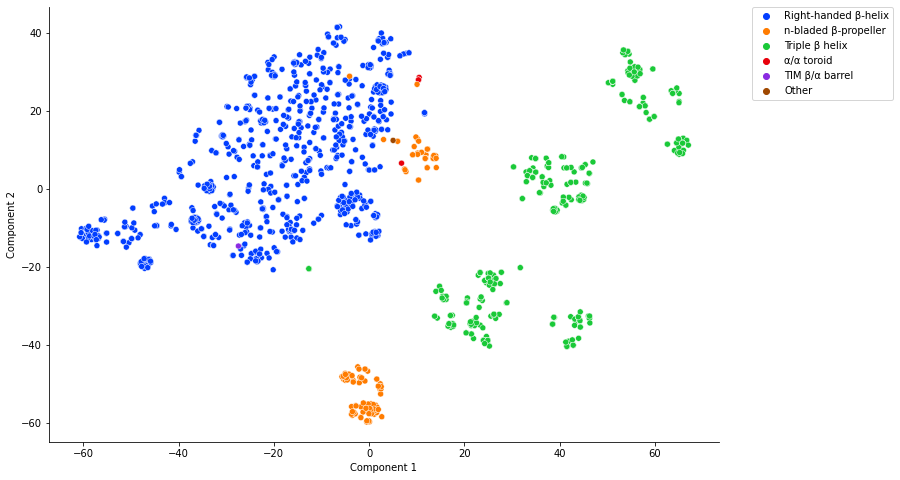

In [53]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
df_embeddings = df_tsne_v2.reset_index()
df_embeddings.drop(columns=[0], inplace=True)

embeddings_2d = tsne.fit_transform(df_embeddings)

# Create a new DataFrame to store 2D embeddings and labels
df_2d = pd.DataFrame(embeddings_2d, columns=['Component 1', 'Component 2'], index=df_tsne_v2.index)

# Add labels to DataFrame
df_2d['label'] = [dico_prot_fold_clean[i] for i in df_tsne_v2.index]

# Generate colors based on labels
palette = sns.color_palette("bright", len(df_2d['label'].unique()))

# Plot the t-SNE representation with labels
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=df_2d, x='Component 1', y='Component 2', hue='label', legend='full', palette=palette)

# Customize the tick positions and labels
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Remove the top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the axis labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{path_work}/tsne_FOLDS.DepoScope.3010.svg', format='svg', bbox_inches='tight', dpi = 500)
plt.show()

In [20]:
triple_helix = [prot for prot in dico_info if dico_info[prot]["fold"] == "triple β helix"]

len(triple_helix)

414

In [7]:
for prot in dico_info : 
    if dico_info[prot]["fold"] == "right-handed beta-helix" :
        dico_info[prot]["fold"] = "right-handed β-helix"
    elif dico_info[prot]["fold"] == "n-bladed beta-propeller" :
        dico_info[prot]["fold"] = "n-bladed β-propeller"

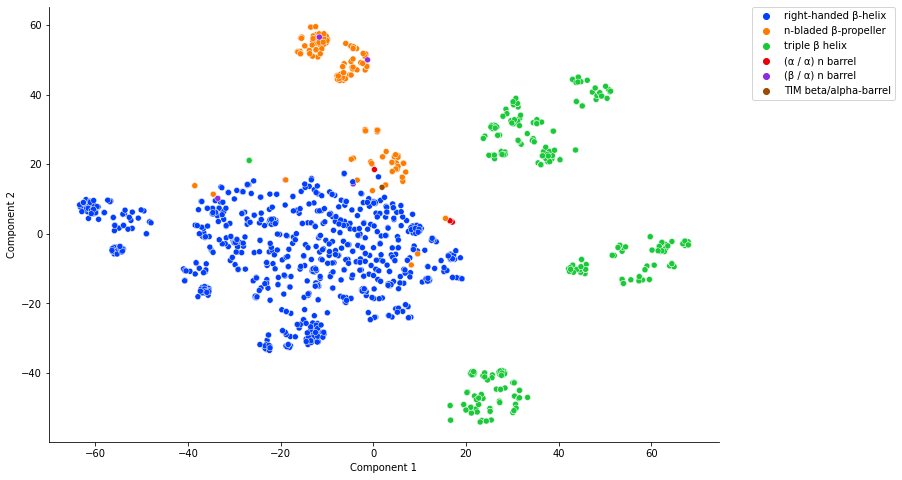

In [11]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataframe and dictionary
# df = pd.read_csv('your_embeddings.csv')
# dico_info = load_your_dictionary()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(df_embeddings)

# Create a new DataFrame to store 2D embeddings and labels
df_2d = pd.DataFrame(embeddings_2d, columns=['Component 1', 'Component 2'], index=df_embeddings.index)

# Add labels to DataFrame
df_2d['label'] = [dico_info[i]['fold'] for i in df_embeddings.index]

# Generate colors based on labels
palette = sns.color_palette("bright", len(df_2d['label'].unique()))

# Plot the t-SNE representation with labels
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=df_2d, x='Component 1', y='Component 2', hue='label', legend='full', palette=palette)

# Customize the tick positions and labels
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Remove the top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the axis labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{path_work}/tsne_FOLDS.DepoScope.svg', format='svg', bbox_inches='tight', dpi = 500)
plt.show()